# Project 1: Email Classifier
- Chloe Wallach
- Roberto Garcia
- Grant Fass

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import json
import glob
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## Load the Data
This section loads in the data. First the glob command is used to get a list of all files under a directory. Then this is iterated through with the JSON load command to open and read in each of the files and store them in another list. This list is then turned into a pandas dataframe using the from records command. The first few records of the table are then displayed as well as information about the data overall. The value counts command shows that there is a class imbalance. It shows that there are about 40000 spam emails and only about 20000 not spam emails.

In [2]:
base_directory = os.path.abspath("./email_json_dataset1")
dir_exists = os.path.exists(base_directory)
file_names = []
if dir_exists:
    file_names = glob.glob(base_directory + "/**")
    print("Num JSON Files: %d" % (len(file_names)))


Num JSON Files: 63542


In [3]:
emails = []
for file in file_names:
    f = open(file)
    dictionary = json.load(f)
    emails.append(dictionary)

print("Type: %s, Len %d" % (type(emails), len(emails)))

Type: <class 'list'>, Len 63542


In [4]:
df = pd.DataFrame.from_records(emails)
df['label'] = df['label'].astype('category')
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   label         63542 non-null  category
 1   to_address    63141 non-null  object  
 2   from_address  63542 non-null  object  
 3   subject       63410 non-null  object  
 4   body          63542 non-null  object  
dtypes: category(1), object(4)
memory usage: 2.0+ MB


In [5]:
df.head(5)

,label,to_address,from_address,subject,body
0,spam,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...
1,ham,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,"Hi, i've just updated from the gulus and I che..."
2,spam,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,authentic viagra\n\nMega authenticV I A G R A...
3,spam,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t..."
4,spam,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,"\n\n\n\n\n\n\nsystem"" of the home. It will ha..."


In [6]:
df['label'].value_counts()

spam    40450
ham     23092
Name: label, dtype: int64

## Extract Features
This uses the count vectorizer to create a CSR matrix based on the bodies of the emails. This is likely tracking which words are in each email.

In [7]:
vectorizer = CountVectorizer(binary=True, min_df=10)
x = vectorizer.fit_transform(df['body'])
x

<63542x32144 sparse matrix of type '<class 'numpy.int64'>'
	with 6388757 stored elements in Compressed Sparse Row format>

## Dim Reduction
The below set of cells train a TruncatedSVD model with 10 components to run dimensionality reduction on the emails. This then prints out the explained variance ratio which shows how much of the variance in the dataset is accounted for by each of the smaller components. This is then displayed in a graph for easier legibility.

In [8]:
vec = TruncatedSVD(n_components=10)
truncated = vec.fit_transform(x)
truncated.shape

(63542, 10)

In [9]:
vec.explained_variance_ratio_

array([0.05746724, 0.02766835, 0.01722694, 0.0130813 , 0.0135758 ,
       0.01083422, 0.01051979, 0.00992035, 0.00802154, 0.00787666])

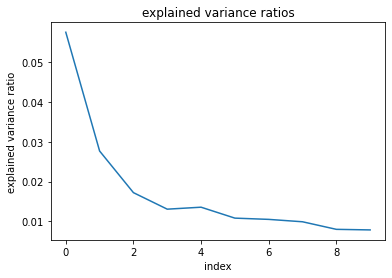

In [10]:
plt.plot(vec.explained_variance_ratio_)
plt.xlabel('index')
plt.ylabel('explained variance ratio')
plt.title('explained variance ratios')
plt.show()

## Use DBSCAN to cluster the data
The below cell creates a graph based on the top two SVD components. From this we can see that there is a pretty good split between the emails that are spam and those that are not spam. This allows us to train an SVC model to evenly split the classes.

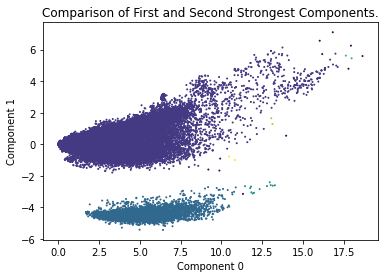

In [11]:
clustering = DBSCAN(min_samples=2).fit(truncated[:, 0:2])
plt.scatter(truncated[:, 0], truncated[:, 1], c=clustering.labels_, s=1)
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('Comparison of First and Second Strongest Components.')
plt.show()

## Set up the data
The below cell splits the data into separate variables for the data and its labels. It then uses the imblearn RandomUnderSampler class to create an even split of data between the two classes.

In [12]:
# y = df['label']
# x = df.drop(columns=['label'])
y_orig = clustering.labels_
x_orig = truncated
print('Original dataset shape {}'.format(Counter(y_orig)))
rus = RandomUnderSampler(random_state=42)
x, y = rus.fit_resample(x_orig, y_orig)
print('Resampled dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 57733, 1: 5780, 2: 12, -1: 11, 3: 2, 4: 2, 5: 2})
Resampled dataset shape Counter({-1: 2, 0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2})


## Run With Undersampling
The below two cells train a SVC classifier with undersampling. This means that there is an equal proportion of both classes in the dataset. This helps to make up for the bias and potential overfitting that would be introduced from having nearly two times as many spam emails as ham emails. The first cell trains the model using a test size of 40%. The second cell trains the model using stratified k-folds cross validation with two splits. From this we can see that the stratification raises the accuracy to about 87% up from 67% without using stratified k-folds cross validation.

x_train: (8, 10)
x_test: (6, 10)
y_train: (8,)
y_test: (6,)
Accuracy: 0.67
Precision: 0.56
Recall: 0.67


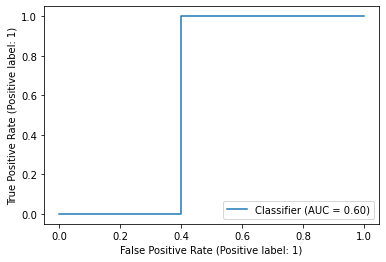

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=42)
print("x_train: %s\nx_test: %s\ny_train: %s\ny_test: %s" % (str(x_train.shape), str(x_test.shape), str(y_train.shape), str(y_test.shape)))
clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy: %.2f" % (metrics.accuracy_score(y_test, y_pred)))
print("Precision: %.2f" % (metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)))
print("Recall: %.2f" % (metrics.recall_score(y_test, y_pred, average='weighted')))
metrics.RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

TRAIN: [ 1  3  5  7  9 11 13] TEST: [ 0  2  4  6  8 10 12]
Accuracy: 0.86
Precision: 0.79
Recall: 0.86
TRAIN: [ 0  2  4  6  8 10 12] TEST: [ 1  3  5  7  9 11 13]
Accuracy: 0.86
Precision: 0.79
Recall: 0.86


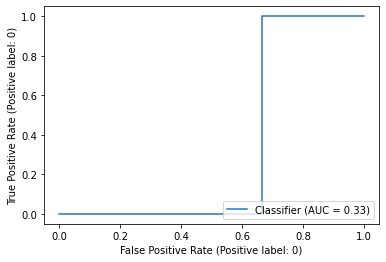

In [14]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(x, y)
for train_index, test_index in skf.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = svm.SVC(kernel='linear')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("Accuracy: %.2f" % (metrics.accuracy_score(y_test, y_pred)))
    print("Precision: %.2f" % (metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)))
    print("Recall: %.2f" % (metrics.recall_score(y_test, y_pred, average='weighted')))
metrics.RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=0)

## Run Without Undersampling
The below cell trains the model using stratified k-folds cross validation across two splits. It does not use the undersampled classes. As such there is a class imbalance. This model reports very high accuracy which means it may be overfitting.

TRAIN: [23069 23088 23101 ... 63539 63540 63541] TEST: [    0     1     2 ... 36262 36280 59119]
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
TRAIN: [    0     1     2 ... 36262 36280 59119] TEST: [23069 23088 23101 ... 63539 63540 63541]
Accuracy: 0.99
Precision: 1.00
Recall: 0.99


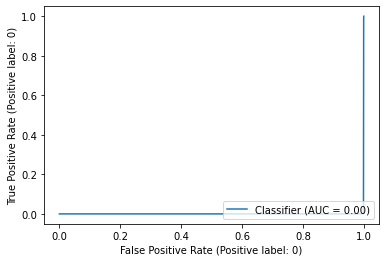

In [15]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(x_orig, y_orig)
for train_index, test_index in skf.split(x_orig, y_orig):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x_orig[train_index], x_orig[test_index]
    y_train, y_test = y_orig[train_index], y_orig[test_index]
    clf = svm.SVC(kernel='linear')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("Accuracy: %.2f" % (metrics.accuracy_score(y_test, y_pred)))
    print("Precision: %.2f" % (metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)))
    print("Recall: %.2f" % (metrics.recall_score(y_test, y_pred, average='weighted')))
metrics.RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=0)